In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from Ricker_functions import *

In [2]:
sm = ps.StanModel(file="MFSVM_WB.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ca37cfdeda3808e1d98ed8092a80410 NOW.


#### Specify model parameters:

In [3]:
T = 2000
m = 5
r = 2
# Lambda = npr.randn(m,r)
# mu = np.append(npr.randn(m),np.zeros(r))
# phi = npr.rand(m+r)
# sigma = np.ones(m+r)
# phi_tr = 2*phi-1;

#### Generate synthetic data:

In [4]:
# y = np.zeros((T,m))
# h = np.zeros((T+1,m+r))
# f = np.zeros((T,r))
# h[0] = mu + sigma/np.sqrt(1-phi_tr**2)*npr.randn(m+r)
# for t in range(T) :
#     h[t+1] = mu + phi_tr*(h[t]-mu) + sigma*npr.randn(m+r)
#     f[t] = np.exp(h[t+1,m:(m+r)]/2)*npr.randn(r)
#     y[t] = np.matmul(Lambda,f[t]) + np.exp(h[t+1,0:m]/2)*npr.randn(m)
    
# data = dict(y=y, h=h, f=f, Lambda=Lambda, mu=mu, phi=phi, sigma=sigma)
# file = open("/xtmp/DC-BATS_data/MFSVM_HMM/data_mfsvm.pkl", "wb")
# pickle.dump(data, file)
# file.close()

In [4]:
file = open("/xtmp/DC-BATS_data/MFSVM_HMM/data_mfsvm.pkl", "rb")
dat = pickle.load(file)
y, h, f, Lambda, mu, phi, sigma = dat['y'], dat['h'], dat['f'], dat['Lambda'], dat['mu'], dat['phi'], dat['sigma']
T = len(y)

#### Specify prior hyperparameters:

In [5]:
a0, b0 = 1., 1.
bmu, Bmu = 0., 1.
Bsigma = 1.
BLambda = 1.

#### Run Stan on full data:

In [ ]:
n_chains = 10

data = dict(T=T, m=m, r=r, y=y, a0=a0, b0=b0, bmu=bmu, Bmu=Bmu, Bsigma=Bsigma, BLambda=BLambda, power=1.)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
print(round((time()-start)/60,2), "minutes to run")
trace = fit.extract()

In [ ]:
file = open("/xtmp/DC-BATS_data/MFSVM_HMM/full_mcmc.pkl", "wb")
pickle.dump(trace, file)
file.close()

#### Divide and conquer:

In [7]:
m = 5
tstarts = np.arange(m).astype(int)
tends = 1 + tstarts
tstarts *= int(T/m)
tends *= int(T/m)

In [ ]:
for i in range(m) :
    tstart, tend = tstarts[i], tends[i]
    data = dict(T=tend-tstart, m=m, r=r, y=y[tstart:tend], a0=a0, b0=b0, bmu=bmu, Bmu=Bmu, Bsigma=Bsigma, BLambda=BLambda, 
                power=T/(tend-tstart))
    fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
    trace = fit.extract()
    file = open("/xtmp/DC-BATS_data/MFSVM_HMM/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(trace, file)
    file.close()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
for i in range(m) :
    tstart, tend = tstarts[i], tends[i]
    data = dict(T=tend-tstart, m=m, r=r, y=y[tstart:tend], a0=a0, b0=b0, bmu=bmu, Bmu=Bmu, Bsigma=Bsigma, BLambda=BLambda, 
                power=1)
    fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
    trace = fit.extract()
    file = open("/xtmp/DC-BATS_data/MFSVM_HMM/mcmc_wb_chunk"+str(i+1)+"_nopower.pkl", "wb")
    pickle.dump(trace, file)
    file.close()

In [11]:
1

1

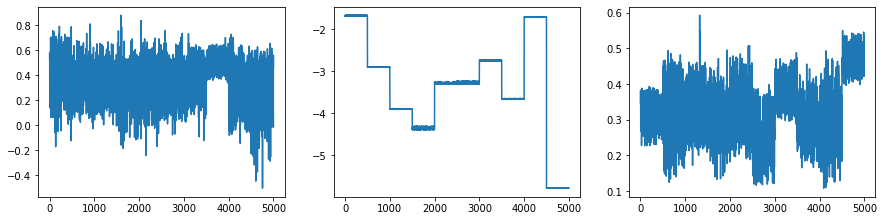

In [26]:
i = 1
k = 2
plt.rcParams['figure.figsize'] = (15, 3.5)
plt.subplot(131)
file = open("/xtmp/DC-BATS_data/MFSVM_HMM/mcmc_wb_chunk"+str(i+1)+"_nopower.pkl", "rb")
trace = pickle.load(file)
plt.plot(trace['mu'][:,i])
plt.subplot(132)
file = open("/xtmp/DC-BATS_data/MFSVM_HMM/mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
trace = pickle.load(file)
plt.plot(trace['mu'][:,i])
plt.subplot(133)
file = open("/xtmp/DC-BATS_data/MFSVM_HMM/full_mcmc.pkl", "rb")
trace = pickle.load(file)
plt.plot(trace['mu'][:,i])